In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [3]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

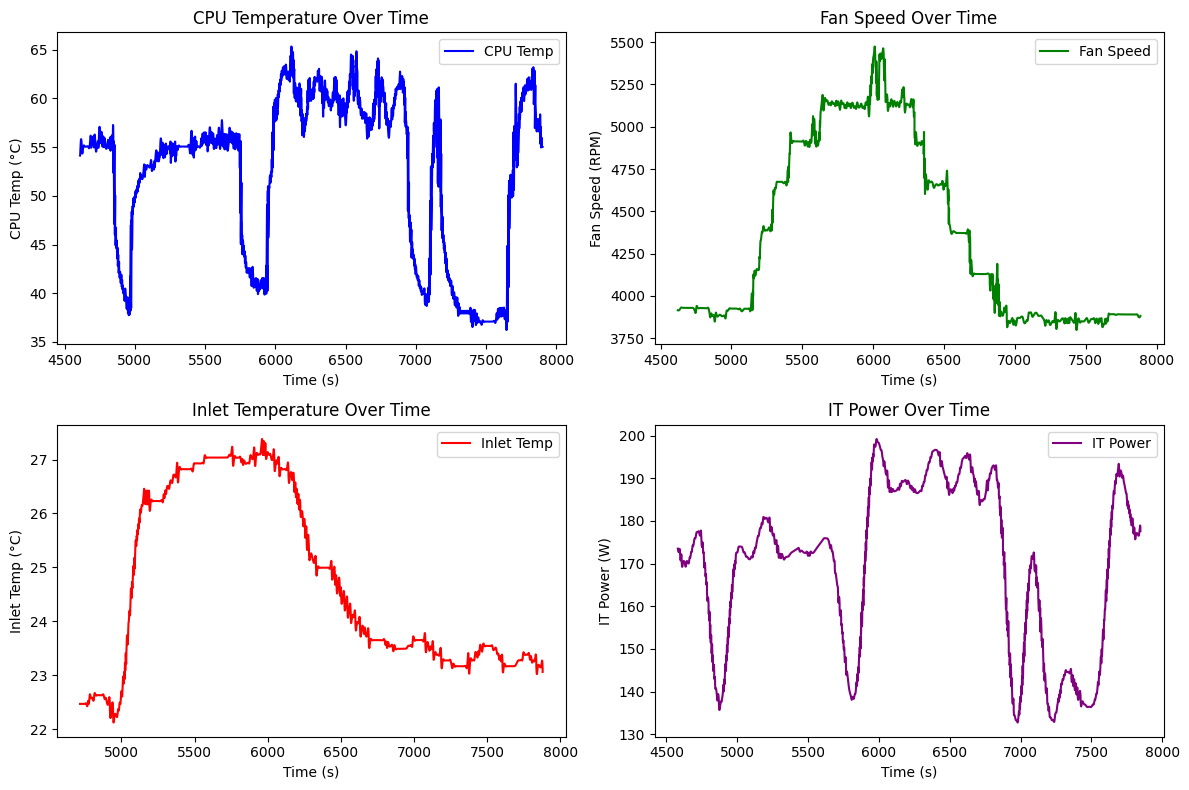

In [4]:
def plot_time_series_subplots(cpu_temp_df, fan_speed_df, inlet_temp_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Third subplot - Inlet Temperature
    axs[1, 0].plot(inlet_temp_df[time_col], inlet_temp_df['inlet_temp'], color='red', label='Inlet Temp')
    axs[1, 0].set_title('Inlet Temperature Over Time')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Inlet Temp (°C)')
    axs[1, 0].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, inlet_temp_new, it_power_new, time_col="time")

In [5]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [6]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

Shape of Final Dataframe = (4255, 5)


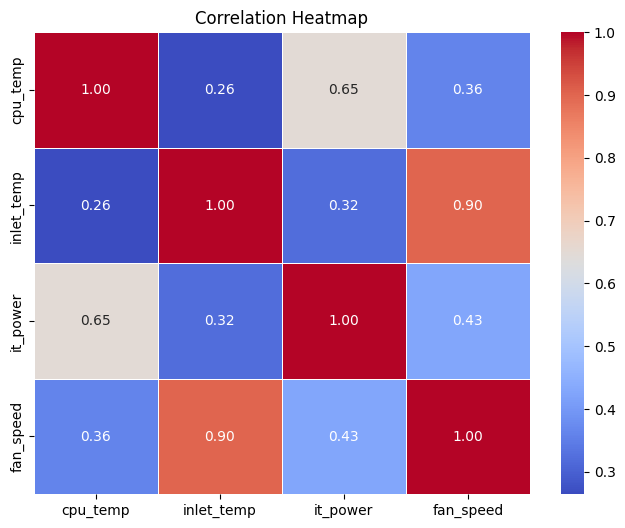

In [7]:
corr_matrix = df[["cpu_temp", "inlet_temp", "it_power", "fan_speed"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [9]:
torch.manual_seed(42)
np.random.seed(42)

## Model with different weightages to input features based on the correlation matrix

In [10]:
import torch
import torch.nn as nn

class WeightedDualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, seq_len, k_steps):
        super(WeightedDualInputAttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.k_steps = k_steps

        self.feature_weights = nn.Parameter(torch.tensor([0.65, 0.36, 0.26], dtype=torch.float32))
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, k_steps)  # k-step prediction

        # Modified MLP to handle fan speed correctly
        self.fan_speed_mlp = nn.Sequential(
            nn.Linear(1, hidden_size),  # Process each timestep separately
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # Ensure output is (batch_size, k_steps, 1)
        )

    def forward(self, x, fan_speed):
        x = x * self.feature_weights.unsqueeze(0).unsqueeze(0)  # Shape: (batch_size, seq_len, input_size)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_len, hidden_size)
        
        attention_weights = torch.softmax(self.attention(out), dim=1)  # (batch_size, seq_len, 1)
        context_vector = torch.sum(attention_weights * out, dim=1)  # (batch_size, hidden_size)

        lstm_output = self.fc(context_vector)  # (batch_size, k_steps)

        # Ensure fan_speed passes correctly through MLP
        fan_speed_contribution = self.fan_speed_mlp(fan_speed).squeeze(-1)  # (batch_size, k_steps)

        return lstm_output + fan_speed_contribution  # Final shape: (batch_size, k_steps)


In [11]:
def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_fan_speed, batch_outputs in loader:
                # batch_fan_speed = batch_fan_speed[:, -1].unsqueeze(-1)  # Take last fan speed value
                
                outputs = model(batch_features, batch_fan_speed)  # Shape: (batch_size, k_steps)

                # Reshape batch_outputs to match outputs
                batch_outputs = batch_outputs[:, -k_step:]  # Keep last k_steps

                # print(outputs.shape)
                # print(batch_outputs.shape)

                loss = criterion(outputs, batch_outputs.squeeze(-1))  
                total_loss += loss.item()
        return total_loss / len(loader)

    # Initial loss before training
    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_fan_speed, batch_outputs in train_loader:
            # batch_fan_speed = batch_fan_speed[:, -1].unsqueeze(-1)  # Fix shape mismatch
            
            optimizer.zero_grad()
            outputs = model(batch_features, batch_fan_speed)  # Shape: (batch_size, k_steps)

            # Ensure batch_outputs shape is (batch_size, k_steps)
            batch_outputs = batch_outputs[:, -k_step:]

            loss = criterion(outputs, batch_outputs.squeeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history


In [30]:
torch.manual_seed(42)
np.random.seed(42)

seq_length = 30  # Historical input window
k_step = 15  # Prediction horizon
input_size = 3  # Features: cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
num_layers = 2
learning_rate = 0.01
num_epochs = 50

In [31]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
model = WeightedDualInputAttentionLSTM(input_size, lstm_hidden_size, num_layers, k_step, seq_length, k_step)
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.6157, Test Loss: 0.2983
Epoch 1/50, Train Loss: 0.0274, Test Loss: 0.0047
Epoch 2/50, Train Loss: 0.0039, Test Loss: 0.0047
Epoch 3/50, Train Loss: 0.0037, Test Loss: 0.0056
Epoch 4/50, Train Loss: 0.0043, Test Loss: 0.0068
Epoch 5/50, Train Loss: 0.0036, Test Loss: 0.0085
Epoch 6/50, Train Loss: 0.0033, Test Loss: 0.0092
Epoch 7/50, Train Loss: 0.0032, Test Loss: 0.0040
Epoch 8/50, Train Loss: 0.0031, Test Loss: 0.0074
Epoch 9/50, Train Loss: 0.0035, Test Loss: 0.0078
Epoch 10/50, Train Loss: 0.0031, Test Loss: 0.0067
Epoch 11/50, Train Loss: 0.0030, Test Loss: 0.0063
Epoch 12/50, Train Loss: 0.0029, Test Loss: 0.0045
Epoch 13/50, Train Loss: 0.0030, Test Loss: 0.0041
Epoch 14/50, Train Loss: 0.0029, Test Loss: 0.0043
Epoch 15/50, Train Loss: 0.0031, Test Loss: 0.0042
Epoch 16/50, Train Loss: 0.0029, Test Loss: 0.0058
Epoch 17/50, Train Loss: 0.0029, Test Loss: 0.0046
Epoch 18/50, Train Loss: 0.0028, Test Loss: 0.0048
Epoch 19/50, Train Loss: 0.0028, Tes

In [32]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score

def evaluate_model(model, test_loader, scaler, df, k_step, split_index):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_features, batch_fan_speed, batch_outputs in test_loader:

            batch_fan_speed = batch_fan_speed[:, -1].unsqueeze(-1)  # Ensure shape is (batch_size, 1)
            outputs = model(batch_features, batch_fan_speed)  # (batch_size, k_steps)

            # Ensure batch_outputs shape matches outputs
            batch_outputs = batch_outputs[:, -k_step:].squeeze(-1)  # (batch_size, k_steps)

            loss = criterion(outputs, batch_outputs)
            test_loss += loss.item()

            predictions.append(outputs.cpu().numpy())  
            actuals.append(batch_outputs.cpu().numpy())

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy arrays
    predictions = np.concatenate(predictions, axis=0)  # Shape: (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0)  # Shape: (num_samples, k_step)

    # Create a dataframe using the original dataframe index
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:, i]

    # Create a dataframe from predictions using the same index
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:, i]

    # Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(
            predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values
        )
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:, -1]

        original_data_actual = scaler.inverse_transform(
            actual_df[['cpu_temp', 'inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values
        )
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:, -1]

    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")

    # Calculate RMSE scores
    rmse_scores = []
    for i in range(k_step):
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse


In [33]:
import matplotlib.pyplot as plt

def plot_results(predictions_df, history, k_step, r2_scores):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df[f'predicted_cpu_temp_{i+1}'], label=f'Predicted CPU Temp {i+1}', color='red')
        plt.plot(predictions_df[f'actual_cpu_temp_{i+1}'], label=f'Actual CPU Temp {i+1}', color='blue', alpha=0.6)
        
        # Increase font size for axis labels and title
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Predicted vs Actual CPU Temperature - Step {i+1}, R2: {r2_scores[i]:.4f}', fontsize=16)
        
        # Increase font size for legend
        plt.legend(fontsize=12)
        plt.show()

    # Plotting training and test loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['train_loss'], label='Training Loss', color='green')
    plt.plot(history['test_loss'], label='Test Loss', color='orange')
    
    # Increase font size for axis labels and title
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('MSE Loss', fontsize=14)
    plt.title('Training vs Test Loss', fontsize=16)
    
    # Increase font size for legend
    plt.legend(fontsize=12)
    plt.show()


In [47]:
def forecast_with_modified_exogenous(model, test_loader, scaler, k_step, modified_fan_speed):
    model.eval()
    
    # Get a single sample from the test loader
    batch_features, batch_exogenous, batch_outputs = next(iter(test_loader))

    # Use only the first sample in the batch
    features = batch_features[0].unsqueeze(0)  # Shape: [1, seq_length, input_size]
    exogenous = batch_exogenous[0].unsqueeze(0)  # Shape: [1, k_step, 1]
    
    # Modify the exogenous input (fan speed)

    modified_exogenous = torch.full_like(exogenous, modified_fan_speed)

    print(features.shape)
    print(exogenous.shape)
    print(modified_exogenous.shape)

    print(f"Original Exogenous Input (Fan Speed): {exogenous.flatten().cpu().numpy()}")

    with torch.no_grad():
        modified_forecast = model(features, modified_exogenous).cpu().numpy().flatten()
        original_forecast = model(features, exogenous).cpu().numpy().flatten()

    # Get actual values for comparison
    actual_values = batch_outputs[0].cpu().numpy().flatten()

    print(modified_forecast.shape)

    # **Inverse Transform Only the CPU Temp Values**
    original_forecast = scaler.inverse_transform(original_forecast.reshape(-1, 1)).flatten()
    modified_forecast = scaler.inverse_transform(modified_forecast.reshape(-1, 1)).flatten()
    actual_values = scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

    # **Plot the results**
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, k_step+1), actual_values, linestyle='-', label='Actual CPU Temp', color='black')
    plt.plot(range(1, k_step+1), original_forecast, linestyle='--', label='Original Forecast', color='blue')
    plt.plot(range(1, k_step+1), modified_forecast, linestyle='--', label=f'Forecast with Fan Speed={modified_fan_speed}',color='red')

    plt.xlabel("Time Steps")
    plt.ylabel("CPU Temperature")
    plt.title("Forecast Comparison with Modified Exogenous Input (Fan Speed)")
    plt.ylim(30, 60) 
    plt.legend()
    plt.show()


In [48]:
predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse = evaluate_model(trained_model, test_loader, scalers["cpu_temp"], combined_df, k_step, split_index)

Test Loss: 0.0045
R2 Score for Step 1: 0.9523
R2 Score for Step 2: 0.9499
R2 Score for Step 3: 0.9499
R2 Score for Step 4: 0.9484
R2 Score for Step 5: 0.9470
R2 Score for Step 6: 0.9479
R2 Score for Step 7: 0.9494
R2 Score for Step 8: 0.9513
R2 Score for Step 9: 0.9515
R2 Score for Step 10: 0.9515
R2 Score for Step 11: 0.9520
R2 Score for Step 12: 0.9523
R2 Score for Step 13: 0.9536
R2 Score for Step 14: 0.9535
R2 Score for Step 15: 0.9535
Average R2 Score: 0.9509
RMSE for Step 1: 1.9194
RMSE for Step 2: 1.9699
RMSE for Step 3: 1.9743
RMSE for Step 4: 2.0069
RMSE for Step 5: 2.0369
RMSE for Step 6: 2.0231
RMSE for Step 7: 1.9965
RMSE for Step 8: 1.9632
RMSE for Step 9: 1.9624
RMSE for Step 10: 1.9662
RMSE for Step 11: 1.9591
RMSE for Step 12: 1.9578
RMSE for Step 13: 1.9339
RMSE for Step 14: 1.9412
RMSE for Step 15: 1.9452
Average RMSE: 1.9704


torch.Size([1, 30, 3])
torch.Size([1, 15, 1])
torch.Size([1, 15, 1])
Original Exogenous Input (Fan Speed): [0.05131203 0.0514401  0.0514722  0.05139478 0.05139478 0.05139478
 0.05139478 0.05139478 0.05120784 0.05120784 0.05091139 0.05091139
 0.05091139 0.05091139 0.05050541]
(15,)


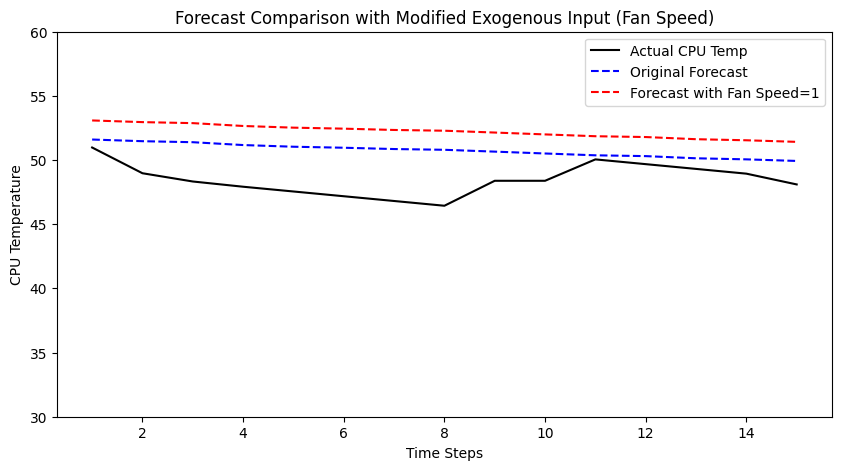

In [49]:
forecast_with_modified_exogenous(model, test_loader, scalers["cpu_temp"], k_step, modified_fan_speed=1)